# IMU Signal Evaluation
In this notebook, we'll evaluate a provided model's performance on new data and explore possible reasons for performance degradation.

# 0. Signal Inspection

We begin by visualizing raw IMU signals using Nexar visualization function from all three sets to check for consistency.

In [140]:
from visualization import signal_viewer
from pathlib import Path

signal_viewer(
    data_dir=Path('data/raw/test'),
    labels_csv=Path('data/test.csv')
)

Inference signals on all axes are noisier than the train/test ones, both on normal and collision cases

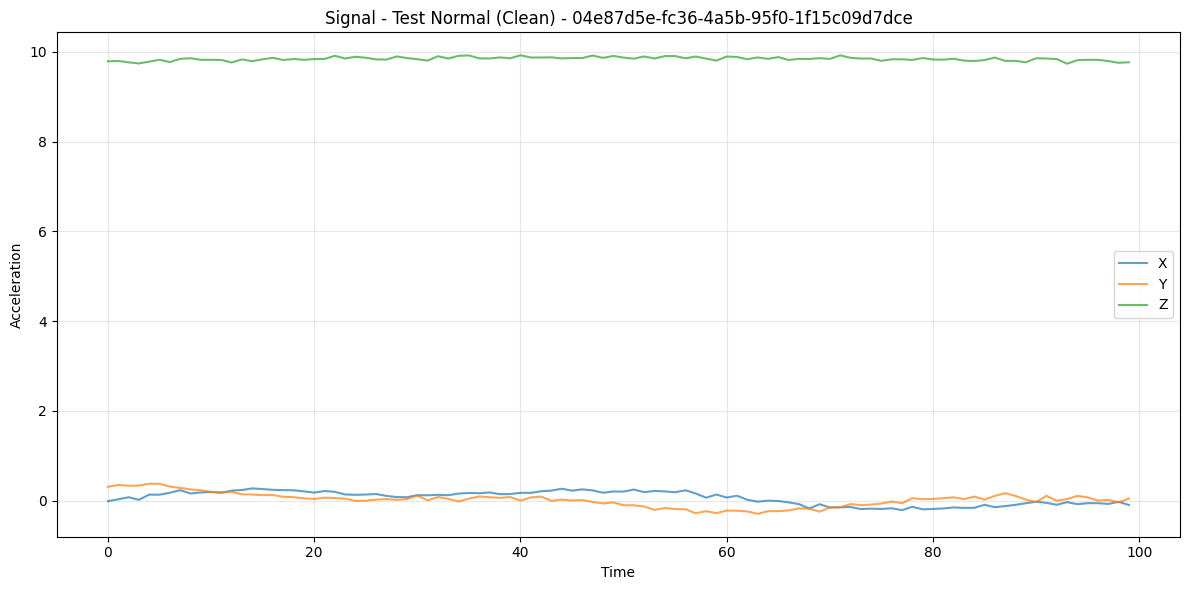

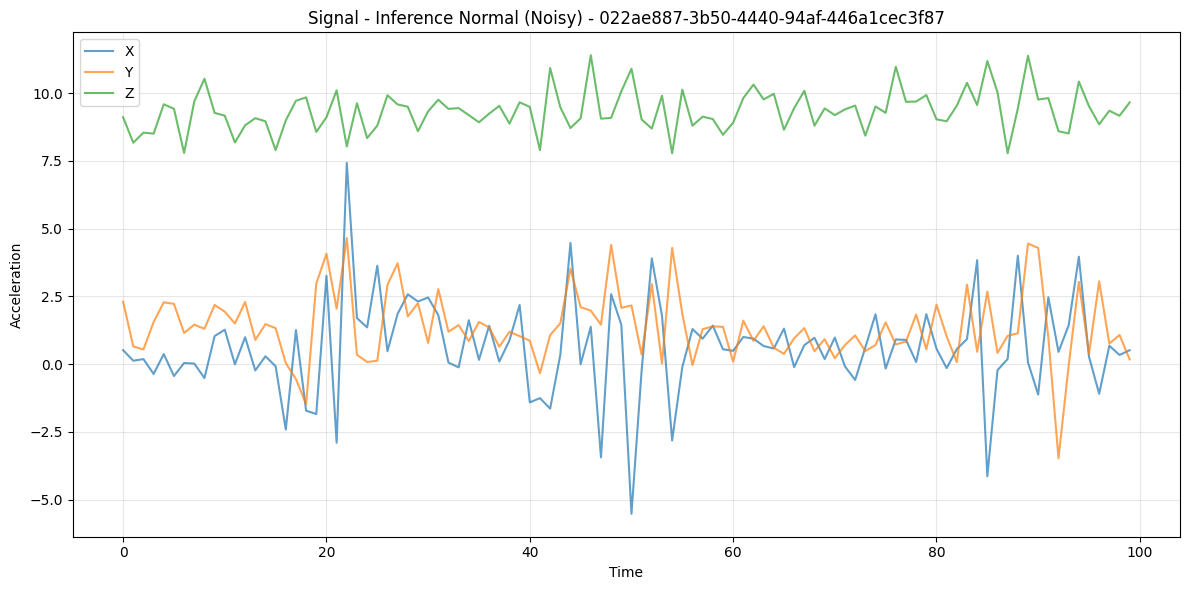

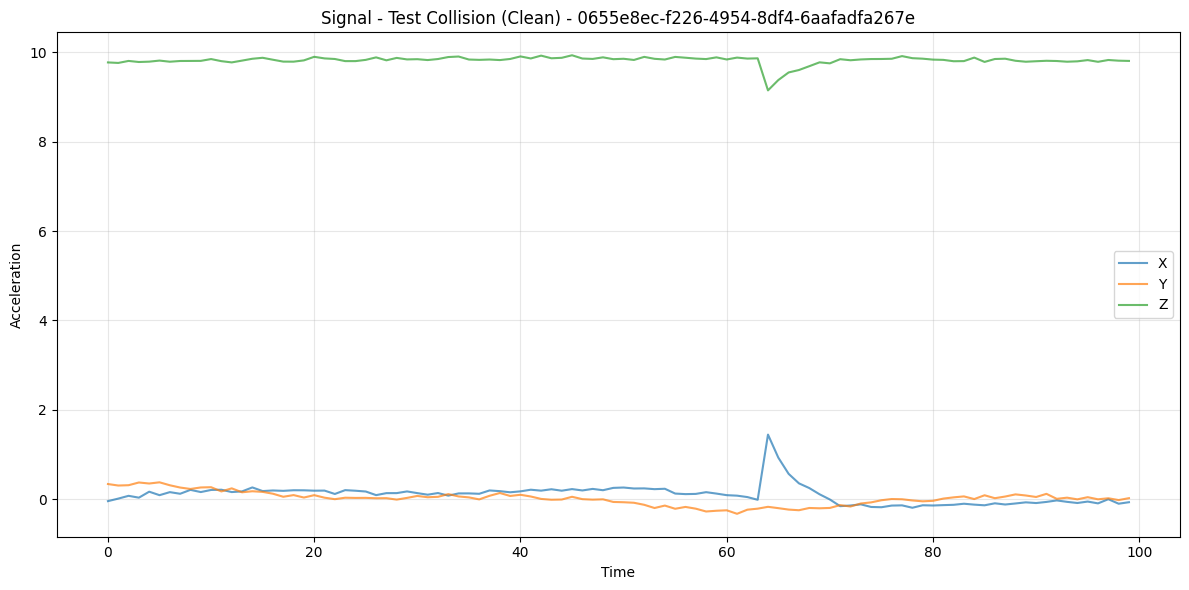

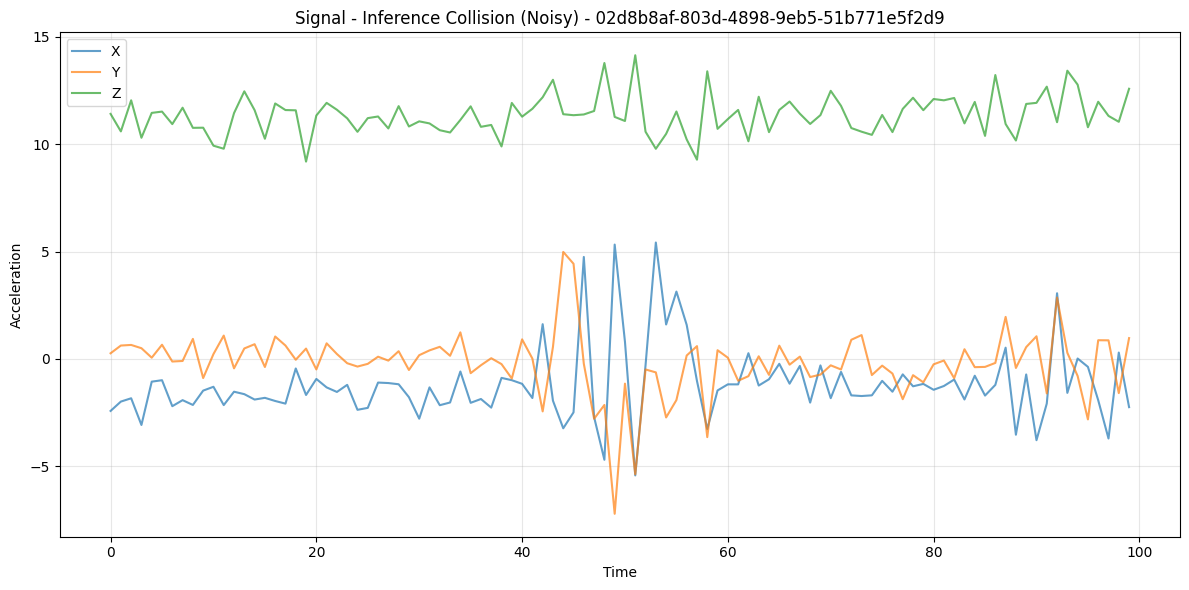

In [141]:

from visualization import load_and_process_sample, plot_signal

def show_comparison(dataset, sample_id, label_prefix):
    signal_array, metadata = load_and_process_sample(f"{dataset}/{sample_id}")
    plot_signal(signal_array, f"{label_prefix} - {sample_id}")

# Representative samples:
test_normal = "04e87d5e-fc36-4a5b-95f0-1f15c09d7dce"         # test set, normal, clean
test_collision = "0655e8ec-f226-4954-8df4-6aafadfa267e"      # test set, collision, clean
inference_normal = "022ae887-3b50-4440-94af-446a1cec3f87"    # inference set, normal, noisy
inference_collision = "02d8b8af-803d-4898-9eb5-51b771e5f2d9" # inference set, collision, noisy

# Clean test signal (normal)
show_comparison("test", test_normal, "Test Normal (Clean)")

# Noisy inference signal (normal)
show_comparison("inference", inference_normal, "Inference Normal (Noisy)")

# Clean test signal (collision)
show_comparison("test", test_collision, "Test Collision (Clean)")

# Noisy inference signal (collision)
show_comparison("inference", inference_collision, "Inference Collision (Noisy)")

Lets quantify the noise for fun

In [142]:

import numpy as np

def compute_noise_score(signal_array):
    # Mean of STD across the 3 axes
    return np.mean(np.std(signal_array, axis=0))

def compute_noise_distribution(set_name):
    folder = Path(f"data/raw/{set_name}")
    all_files = sorted(folder.glob("*.npz"))
    
    noise_scores = []
    for f in all_files:
        signal, _ = load_and_process_sample(f"{set_name}/{f.stem}")
        score = compute_noise_score(signal)
        noise_scores.append((f.stem, score))
    
    return noise_scores

In [143]:
inference_noise = compute_noise_distribution("inference")
test_noise = compute_noise_distribution("test")

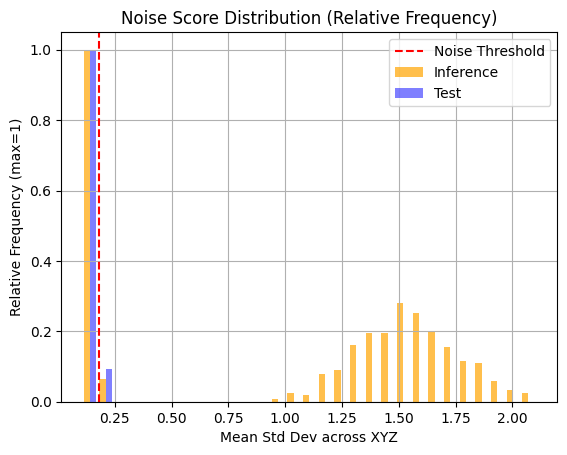

In [144]:
import matplotlib.pyplot as plt

inf_scores = np.array([s for _, s in inference_noise])
test_scores = np.array([s for _, s in test_noise])

# Create histograms with same bins
bins = np.linspace(
    min(inf_scores.min(), test_scores.min()),
    max(inf_scores.max(), test_scores.max()),
    30
)

inf_hist, _ = np.histogram(inf_scores, bins=bins)
test_hist, _ = np.histogram(test_scores, bins=bins)

# Normalize to max=1 due to large different in sample number (much more inferences)
inf_hist = inf_hist / inf_hist.max()
test_hist = test_hist / test_hist.max()

# Plot bar charts
bin_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.4

plt.bar(
    bin_centers - width/2,
    inf_hist,
    width=width,
    alpha=0.7,
    label='Inference',
    color='orange'
)
plt.bar(
    bin_centers + width/2,
    test_hist,
    width=width,
    alpha=0.5,
    label='Test',
    color='blue'
)

plt.axvline(
    np.mean(test_scores) + 2*np.std(test_scores),
    color='red',
    linestyle='--',
    label='Noise Threshold'
)
plt.title("Noise Score Distribution (Relative Frequency)")
plt.xlabel("Mean Std Dev across XYZ")
plt.ylabel("Relative Frequency (max=1)")
plt.legend()
plt.grid(True)
plt.show()


I define noisy sample threshold as 2*std above test mean

In [145]:

noise_threshold = np.mean(test_scores) + 2 * np.std(test_scores)

noisy_inference_samples = [f for f, score in inference_noise if score > noise_threshold]
print(f"Noisy inference samples: {len(noisy_inference_samples)} / {len(inference_noise)}")

noisy_test_samples = [f for f, score in test_noise if score > noise_threshold]
print(f"Noisy test samples: {len(noisy_test_samples)} / {len(test_noise)}")

Noisy inference samples: 315 / 473
Noisy test samples: 15 / 200


# 1. Evaluate the model on the inference set

In [110]:

from extract_features import process_dataset
process_dataset('inference')


[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [00:02<00:00, 201.34it/s]

Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,2.58,2.36,9.00,-5.20,14.20,0.19,1.40,31,1223.24,3.00,...,12,49,996,S603575,v1.3.0,ok,79,5.57,4g,model_c
1,-0.11,2.19,10.29,-5.28,15.57,2.16,7.70,5,478.97,0.34,...,22,75,607,S949312,v1.2.4,ok,81,3.18,4g,model_c
2,0.06,0.15,0.29,-0.21,0.50,-0.41,-1.21,15,2.55,0.02,...,30,52,482,S223545,v1.2.3,recent,95,2.99,4g,model_b
3,1.35,2.49,11.11,-6.37,17.48,0.76,3.15,15,801.92,1.42,...,11,36,463,S993755,v1.2.3,pending,47,9.74,4g,model_a
4,0.06,0.14,0.28,-0.25,0.53,-0.44,-1.16,17,2.38,0.02,...,13,41,759,S734746,v1.2.4,recent,37,3.62,wifi,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.06,0.14,0.30,-0.23,0.53,-0.39,-1.22,14,2.37,0.02,...,15,57,750,S165342,v1.2.4,ok,54,9.76,4g,model_c
469,0.16,2.51,8.35,-9.57,17.92,0.29,3.36,10,632.52,1.81,...,12,76,900,S653588,v1.3.0,pending,23,8.20,4g,model_a
470,-0.55,2.59,6.55,-8.43,14.98,-0.19,1.45,11,701.81,1.41,...,22,77,11,S945979,v1.3.0,pending,80,5.03,5g,model_b
471,-0.56,1.85,4.83,-6.74,11.57,-0.10,1.83,9,374.27,1.99,...,29,50,831,S424057,v1.3.0,pending,83,1.70,5g,model_c


# 2. Compare Performance

In [146]:

# Quick reminder (to myself) of the standard metrics meaning/calcuation:

# Accuracy  = (True Positives + True Negatives) / All Predication
# Precision = True Positives / (True Positives + False Positives)
# Recall    = (True Positives + False Negatives) / True Positives
# F1        = 2× (Precision + Recall) / Precision×Recall


# Reference performance on testset

In [147]:

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report)

# Loading test data
test_data = pd.read_csv("data/test.csv")
true_labels = test_data["label"]
features_test = test_data.drop(columns=["label", "sample_id"], errors="ignore")

# Predict using the trained model
predictions_test = model.predict(features_test)

# Compute main classification metrics
accuracy = accuracy_score(true_labels, predictions_test)
precision = precision_score(true_labels, predictions_test, average="weighted")
recall = recall_score(true_labels, predictions_test, average="weighted")
f1 = f1_score(true_labels, predictions_test, average="weighted")

# Display the evaluation summary
print("Evaluation Results on Test Set")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}\n")
print("Classification Report:\n")
print(classification_report(true_labels, predictions_test))

Evaluation Results on Test Set
Accuracy: 0.945
Precision: 0.950
Recall: 0.945
F1 Score: 0.945

Classification Report:

              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



# Confusion matrix for the testset

Confusion Matrix
                Pred collision  Pred normal
True collision              89           11
True normal                  0          100


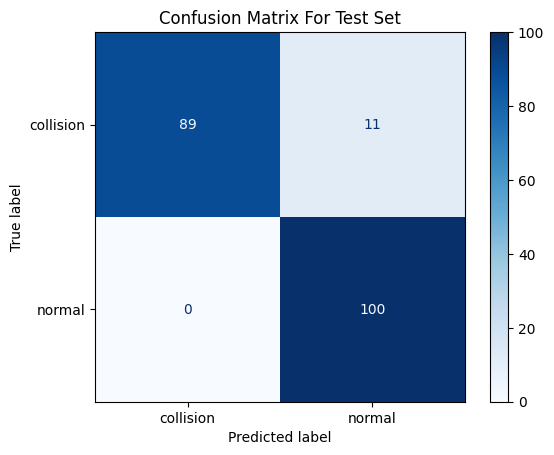

In [148]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['collision', 'normal']

cm = confusion_matrix(true_labels, predictions_test, labels=labels)

print("Confusion Matrix")
print(pd.DataFrame(cm, index=[f"True {l}" for l in labels], columns=[f"Pred {l}" for l in labels]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix For Test Set")
plt.show()

# Performance on inference set

Inference Set Evaluation:
Accuracy:  0.645
Precision: 0.738
Recall:    0.645
F1 Score:  0.607

Detailed Report:

              precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61       473



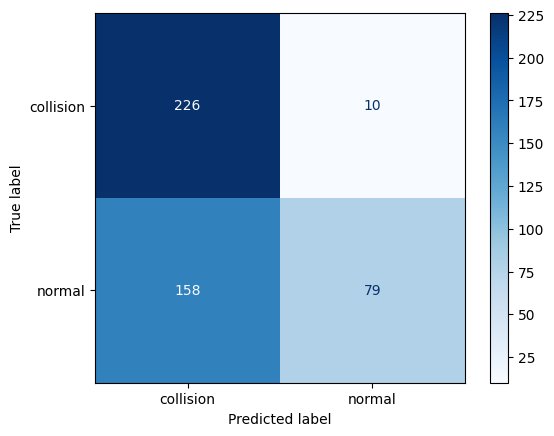

In [149]:
inference_features = pd.read_csv("data/inference.csv")
inference_labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

# Load the model pipeline
pipeline = joblib.load("models/imu_pipeline.pkl")

# If the features include sample IDs, align to ensure matching order
if 'sample_id' in inference_features.columns:
    inference_features = (
        inference_features
        .set_index("sample_id")
        .loc[inference_labels["sample_id"]]
        .reset_index()
    )

# Separate predictors and targets
X_inference = inference_features.drop(columns=["sample_id"], errors="ignore")
y_true = inference_labels["label"]

# Predict on inference
y_pred = pipeline.predict(X_inference)

# Evaluate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("Inference Set Evaluation:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("\nDetailed Report:\n")
print(classification_report(y_true, y_pred))

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=["collision", "normal"])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["collision", "normal"]
)
disp.plot(cmap="Blues", values_format="d")

# Summary Comparison Testset Vs. Inference:

In [150]:

#| Metric    | Test Set | Inference Set |
#| --------- | -------- | ------------- |
#| Accuracy  | 0.945    | 0.645         |
#| Precision | 0.950    | 0.738         |
#| Recall    | 0.945    | 0.645         |
#| F1 Score  | 0.945    | 0.607         |


- The table above highlights a significant drop in all performance metrics when evaluating the model 
on the inference set compared to the test set.
- The accuracy drops from 94.5% to 64.5%, with similar declines in precision, recall, and F1 score.


# Lets EDA:

How do the feature distribution between test and inference differ ?

We start by checking feature importance (not necessary but interesting and there are a lot of features)



Top 10 Important Features:
          feature  importance
30  max_delta_mag        0.10
11          y_max        0.08
28        mag_std        0.07
9          y_mean        0.06
35     y_fft_mean        0.04
17       y_energy        0.04
15     y_kurtosis        0.04
13        y_range        0.04
23         z_skew        0.03
14         y_skew        0.03


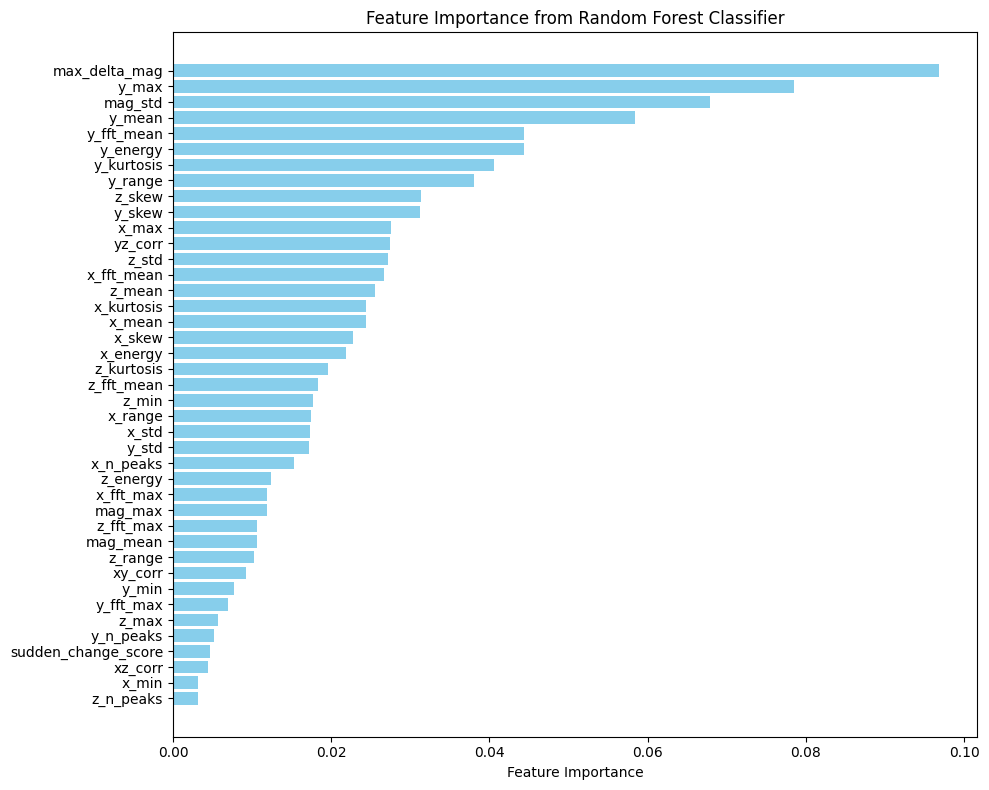

In [151]:

df_inference = pd.read_csv("data/inference.csv")
labels_inference = pd.read_csv("data/manual_annotation/inference_labels.csv")

# Make sure features and labels align by sample_id if exists
if 'sample_id' in df_inference.columns:
    df_inference = df_inference.set_index('sample_id').loc[labels_inference['sample_id']].reset_index()

# Extract true labels and features
y_true = labels_inference['label']

# 41 features the model was trained on (checked separately, partial to the 50+ features that exist in the files):
training_features = ['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
                     'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
                     'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std', 'z_max',
                     'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks', 'z_energy', 'mag_mean',
                     'mag_std', 'mag_max', 'max_delta_mag', 'sudden_change_score', 'x_fft_max',
                     'x_fft_mean', 'y_fft_max', 'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr',
                     'xz_corr', 'yz_corr']

# Filter features dataframe to only these chosen columns
X_inference_aligned = df_inference[training_features]

# Predict labels
y_pred = model.predict(X_inference_aligned)

# Extract feature importances from the model's classifier
feature_importances = model.model.feature_importances_

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': training_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importances_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()


# Now lets take the 4 most important features and check their distributions on test and inference

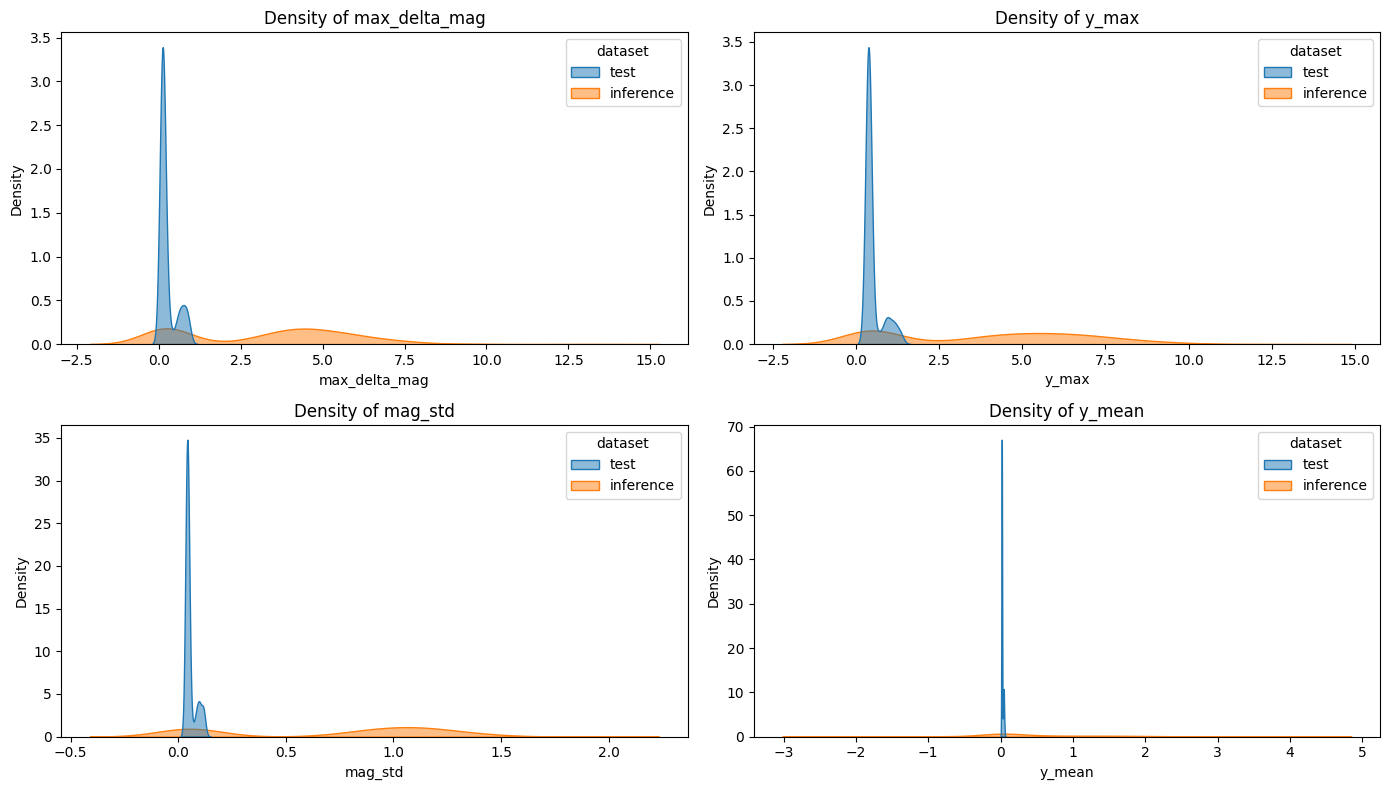

In [153]:
import seaborn as sns

# Load test set
df_test = pd.read_csv("data/test.csv")
df_test["dataset"] = "test"

# Load inference set
df_inference = pd.read_csv("data/inference.csv")
df_inference["dataset"] = "inference"

# Select 4 most important features to compare (as extracted from model before)
features = ["max_delta_mag", "y_max", "mag_std", "y_mean"]

# Combine datasets for plotting
df_plot = pd.concat([df_test, df_inference], ignore_index=True)

plt.figure(figsize=(14, 8))
for i, feat in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(data=df_plot, x=feat, hue="dataset", common_norm=False, fill=True, alpha=0.5)
    plt.title(f"Density of {feat}")

plt.tight_layout()
plt.show()


# Feature distribution for all features (checking mean)

In [154]:

# List numeric features (same filtering as before)
numeric_features = [
    col for col in df_test.columns
    if df_test[col].dtype in [float, int]
    and col not in ['sample_id']
]

# Compute mean per feature
summary_test = df_test[numeric_features].mean().to_frame("test_mean")
summary_inf = df_inference[numeric_features].mean().to_frame("inference_mean")

# Compute relative % difference
summary = summary_test.join(summary_inf)
summary["diff_percentage"] = ((summary["inference_mean"] - summary["test_mean"]) / summary["test_mean"]) * 100

# Also keep absolute % diff for sorting
summary["abs_diff_percetage"] = summary["diff_percentage"].abs()

# Sort by absolute difference
summary_sorted = summary.sort_values(by="abs_diff_percetage", ascending=False)

pd.set_option("display.float_format", lambda x: "%.2f" % x)
print(summary_sorted)


                     test_mean  inference_mean  diff_percentage  \
y_energy                  2.66          287.91         10726.66   
x_energy                  3.96          403.63         10103.35   
y_mean                    0.02            0.48          2234.05   
x_min                    -0.22           -4.53          1959.43   
mag_std                   0.05            0.72          1232.82   
max_delta_mag             0.25            3.29          1215.13   
x_fft_mean                1.09           13.97          1178.62   
y_fft_mean                0.88           10.79          1123.60   
x_range                   0.88            9.87          1015.85   
z_std                     0.05            0.60           997.67   
y_min                    -0.29           -3.01           941.97   
z_range                   0.34            3.44           923.83   
y_range                   0.78            6.97           791.00   
y_fft_max                 8.79           77.19           777.6

# Lets watch the metadata separately:

In [155]:

df_inference = pd.read_csv("data/inference.csv")
df_inference["dataset"] = "inference"

# Concat test and inference
df_all = pd.concat([df_test, df_inference], ignore_index=True)

# Categorical columns
categorical_cols = [
    "sensor_source",
    "firmware_version",
    "calibration_status",
    "device_model",
    "weather",
    "network_type",
    "road_type",
    "time_of_day",
    "speed_bin",
    "vehicle_type"
]

# Numeric columns
numeric_cols = [
    "temperature",
    "humidity",
    "altitude",
    "gps_accuracy",
    "battery_level"
]

# Display counts for categorical columns
for col in categorical_cols:
    print(f"\n=== {col} value counts by dataset ===")
    print(df_all.groupby("dataset")[col].value_counts())

# Display means/stdevs for numeric columns
print("\n=== Numeric Columns Summary ===")
print(df_all.groupby("dataset")[numeric_cols].agg(["mean", "std"]))



=== sensor_source value counts by dataset ===
dataset    sensor_source
inference  phone            309
           camera           164
test       camera           200
Name: count, dtype: int64

=== firmware_version value counts by dataset ===
dataset    firmware_version
inference  v1.2.4              166
           v1.3.0              163
           v1.2.3              144
test       v1.2.4               79
           v1.3.0               67
           v1.2.3               54
Name: count, dtype: int64

=== calibration_status value counts by dataset ===
dataset    calibration_status
inference  pending               171
           ok                    167
           recent                135
test       recent                 72
           pending                65
           ok                     63
Name: count, dtype: int64

=== device_model value counts by dataset ===
dataset    device_model
inference  model_a         162
           model_b         157
           model_c         154

# 3. EDA Summary: Test vs. Inference Set

ⓐ Data Distribution Differences:

    Visualizations of the 4 top influencing features (by feature importance): max_delta_mag, y_max, mag_std and 
    y_mean, show substantial distribution shifts between the test set and the inference set. 
    For example, the inference data exhibits significantly higher variance and much larger 
    ranges in these features, suggesting highly different / noisier sensor readings.
    
    Beyond just the model’s top features, several other signals (such as x_energy and y_energy) also show extreme  
    shifts, some exceeding ten thousand percent in mean difference.

ⓑ Sensor Source Differences:

    Additional analysis revealed that the inference set is primarily composed of samples 
    collected via phone sensors, while the test set is exclusively from camera sensors. 
    This is an important distinction: phone sensor data typically has higher noise levels and 
    different signal properties, which were not represented during training.
    
    It makes complete sense and might be due to lower grade hardware / accelerators in phones (comparing to 
    cameras) or from the installation in the car.

ⓒ Impact on Model Performance:

    Model performance drops sharply on the inference set compared to the test set (e.g., accuracy declines 
    from ~94.5% to ~64.5%). This degradation is likely due to the observed distribution shifts and sensor 
    type differences.

## Conclusion ##

    The combination of sensor type mismatch (phone vs. camera), feature distribution shifts, 
    and increased noise are the most probable root causes of the performance degradation on the 
    inference data.

# 4. Immediate workarounds:

ⓐ Retrain the Model Including Inference Data

    Why?
    By incorporating the labeled inference data into training, the model will learn to recognize this new 
    distribution, reducing performance gaps caused by unseen sensor types and noisier signals.

    How?
    Merge train.csv with the labeled inference.csv to create a combined dataset.

    Carefully check data balance between classes (e.g., driving behaviors) and sensor types (camera vs. phone) to 
    avoid introducing bias.

    Create a new train/test split that preserves this balance:

    I would use ~50–70% of the combined data for training.

    Reserve the rest as a holdout test set to evaluate whether retraining improves performance on phone data.

    Impact:
    Helps the model adapt to the shifted domain right away, with a balanced dataset reflecting real-world
    conditions and a clean split for validation.

ⓑ Normalize/Standardize Features

    Why?
    Large differences in scale (e.g., x_energy 100x bigger) may distort the classifier.

    How?
    Add a StandardScaler or RobustScaler in the preprocessing pipeline.

    Impact:
    Reduces the effect of extreme values, making features more comparable.

ⓒ Apply Signal Smoothing or Filtering

    Why?
    Many inference samples are noisy, causing unreliable statistical features.

    How?
    Pre-filter raw signals before feature extraction (e.g., low-pass filter or rolling mean).

    Impact:
    Makes extracted features more robust to noise.

ⓓ Use Noise-Robust Features

    Why?
    Some current features (e.g., max_delta_mag, energy) are very sensitive to noise.

    How?
    Add features such as median absolute deviation or quantiles.

    Impact:
    Reduces volatility caused by outliers.


ⓔ Adjust the Classification Threshold

    Why?
    If precision or recall is more critical (e.g., minimizing missed collisions), threshold tuning could help.

    How?
    Analyze ROC curves and set a threshold that balances performance.

    Impact:
    Quick improvement without retraining.


# 5. Long-Term Solutions

ⓐ Data Augmentation & Expanded Training Set
     
    Why?
    The current model fails on new sensor types and conditions because training data lacked diversity. 
    Broader data helps the model generalize to real world scenarios.

    How?
    Collect and label more data covering all sensor types (phones, cameras, etc.)

    Ensure all other parameters in the meta data are represented equaly.

    Impact:
    Improves robustness by training on the same variability seen in production.

ⓑ Include Sensor Metadata as Features

    Why?
    The model is currently blind to which sensor produced the data. 
    This information is critical because sensors have different noise and behavior profiles.

    How?
    Add sensor_source and device_model as categorical features
    Encode with one-hot encoding or embeddings

    Impact:
    Gives the model context to learn different patterns and priors per sensor type.

ⓒ Re-Training and Cross-Validation Strategy

    Why?
    To ensure the model generalizes across all sensor and scenario combinations.

    How?
    Retrain on the expanded, cleaned dataset
    Use stratified cross-validation including sensor type
    Evaluate performance separately per sensor type

    Impact:
    Improves confidence in consistent model performance across conditions.

ⓓ Model Ensembling
    
    Why?
    Different sensor types may be better handled by specialized models.

    How?
    Train separate models for phones and cameras
    Use a meta model or a rule to select the most appropriate model dynamically

    Impact:
    Improves accuracy by using models that are each fine-tuned to their specific sensor data instead of forcing a 
    single model to generalize across everything.



# ❓ Questions to Reflect On


Most questions were answered within the analysis, but to summarize:

- What do you observe when comparing the model’s predictions on the new data to its known performance?



The model’s performance degraded substantially when applied to the inference dataset.

Accuracy dropped from ~94.5% on the test set to ~64.5% on inference data.

Recall and F1 metrics also declined by more than 30%.

This suggests the model is unable to generalize reliably to this new data distribution.



- Is there anything in the data that might explain differences in behavior?



Yes. EDA shows several clear differences:

The feature distributions of important signals (e.g., max_delta_mag, y_max, mag_std, y_mean) shifted by hundreds to thousands of percent.

The sensor_source field revealed that most of inference samples came from phones rather than cameras, which were dominant in the training/test data.



- Can you identify patterns or trends related to when the model succeeds or fails?


Yes:

The model performs much worse on samples with higher signal variance and noise, as seen in the inference set.

The failure rate increases on samples originating from phone sensors.

Noisy signals are highly correlated with misclassification of normal driving as collisions or vice versa.



- Are there signals or features that seem to affect the model’s reliability?

Yes:

Features related to energy and variance of acceleration, such as mag_std, y_energy, and max_delta_mag, had the largest distribution shifts and contributed most to prediction errors.

These features were also among the most important during training, amplifying the impact of their mismatch.


- What could be done in the short term to handle the current situation?

Retrain with the new data:
Combine the original training data with the labeled inference data so the model can learn how the phone sensor data looks. Make sure the classes (e.g., driver behaviors) and sensor types stay balanced. Keep part of this combined data aside as a new test set to check if retraining helps.

Normalize feature scales:
Some features have much bigger ranges than others, which can confuse the model. Use scaling (like StandardScaler) to make all features more comparable.

Filter noisy signals:
Apply smoothing (for example, a rolling average) to reduce noise in the raw sensor signals before extracting features.

Use more robust features:
Add features that are less sensitive to outliers and noise, like median deviation or quantiles, instead of only relying on energy or max delta.

Adjust the decision threshold:
If retraining is not possible right away, tune the classification threshold to improve precision or recall based on what matters most (e.g., fewer false alarms).


- What are potential long-term steps to improve model performance in similar scenarios?

Collect and label more diverse data:
Gather additional training data that covers all sensor types (phones, cameras) and different conditions (weather, road type, time of day). This makes the model better prepared for what it will see in production.

Add sensor information as input features:
Include fields like sensor type and device model in the training data so the model knows where the signal came from. This helps it learn to handle the differences between sensors.

Retrain with better cross-validation:
After collecting more data, retrain the model using cross-validation that keeps sensor types balanced in each fold. Check performance separately for each sensor to confirm it works well across the board.

Use separate models for different sensors:
Train dedicated models for phone and camera data. Then either combine them in an ensemble or set up a rule to pick the right model for each incoming sample.


- What would you want to explore further if given more time or data?


If more resources were available, I would:

Label more phone sensor samples to balance the training dataset.

Conduct systematic experiments to quantify the impact of each metadata factor (weather, road type, speed) on performance.

Test advanced domain adaptation techniques (e.g., transfer learning) to bridge the gap between camera and phone data distributions.

Explore time-series modeling approaches that better capture temporal dynamics.


- What assumptions did the model rely on during training — and are they still valid?


The key assumptions were:

The distribution of sensor signals in training and deployment would be similar (mostly camera data).

The noise characteristics of input data were stable and consistent.

These assumptions are no longer valid, as the inference set contains a large proportion of phone sensor data with higher noise and different feature distributions.


